In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.cluster import DBSCAN
pd.options.mode.chained_assignment = None

## Bike Loans dataset

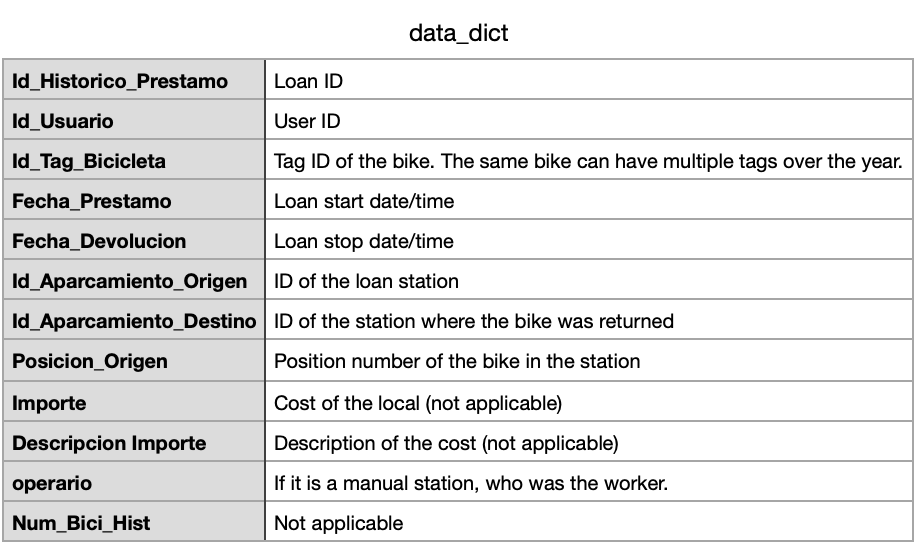\

In [2]:
loans_df = pd.read_csv('data/bike_loans.csv', sep=';',encoding='utf-8')

In [3]:
loans_df.columns = ['loan_id', 'user_id','bike_tag_id', 'time_start_loan', 'time_stop_loan', "station_loan_id", "origin_position", "station_returned_id", 'destined_position', "cost", "descr", "worker_name", "not_app"]


In [4]:
loans_df = loans_df.drop(['cost', 'descr', 'not_app'], axis = 1)

In [5]:
loans_df

loan_id  user_id   bike_tag_id          time_start_loan  \
0          6501462    18701  000017B00743  2017-06-21 14:22:11.000   
1          6501318    41811  000017AFF83C  2017-06-21 14:07:18.000   
2          6501489    96620  000017AFFB6F  2017-06-21 14:25:11.000   
3          6501001    16055  0000182A3B7B  2017-06-21 13:35:52.000   
4          6501421     6431  000017AFE810  2017-06-21 14:17:56.000   
...            ...      ...           ...                      ...   
14225350  17272860    26650  00001B7DE4E2  2021-04-20 18:46:57.000   
14225351  17272686   151968  000030778CC7  2021-04-20 18:28:09.000   
14225352  17272992   155196  000037FDF432  2021-04-20 18:59:53.000   
14225353  17272844   144508  000026B3E61C  2021-04-20 18:45:42.000   
14225354  17272787   120899  0000B5C6F1E2  2021-04-20 18:39:06.000   

                   time_stop_loan  station_loan_id  origin_position  \
0         2017-06-21 14:38:29.000                8                1   
1         2017-06-21 14:39:06.000               56                6   
2         2017-06-21 14:39:07.000               36               25   
3         2017-06-21 14:39:22.000                8                1   
4         2017-06-21 14:39:26.000               56               14   
...                           ...              ...              ...   
14225350  2021-04-20 19:07:25.000               45               18   
14225351  2021-04-20 19:08:00.000               96               20   
14225352  2021-04-20 19:08:59.000               56               37   
14225353  2021-04-20 19:13:45.000               61                1   
14225354  2021-04-20 19:51:17.000                8                1   

          station_returned_id  destined_position     worker_name  
0                        43.0                1.0    jhon.castano  
1                        54.0                NaN         monitor  
2                         9.0               13.0             NaN  
3                         9.0                6.0             NaN  
4                        54.0                NaN         monitor  
...                       ...                ...             ...  
14225350                 89.0               11.0             NaN  
14225351                 96.0               15.0             NaN  
14225352                 89.0               15.0             NaN  
14225353                  1.0                1.0  johan.granados  
14225354                  2.0                1.0  beatriz.osorio  

[14225355 rows x 10 columns]

In [6]:
# Converting date & time columns to datetime format

loans_df['time_start_loan'] = pd.to_datetime(loans_df['time_start_loan'])
loans_df['time_stop_loan'] = pd.to_datetime(loans_df['time_stop_loan'])

In [7]:
#Creating year, month, and weekday columns

loans_df['year'] = loans_df['time_start_loan'].dt.year
loans_df['month'] = loans_df['time_start_loan'].dt.month
loans_df['weekday'] = loans_df['time_start_loan'].dt.weekday
loans_df['hour'] = loans_df['time_start_loan'].dt.hour

print(f"We have data for the following years:\n{np.sort(loans_df['year'].unique())}")

We have data for the following years:
[2014 2015 2016 2017 2018 2019 2020 2021]


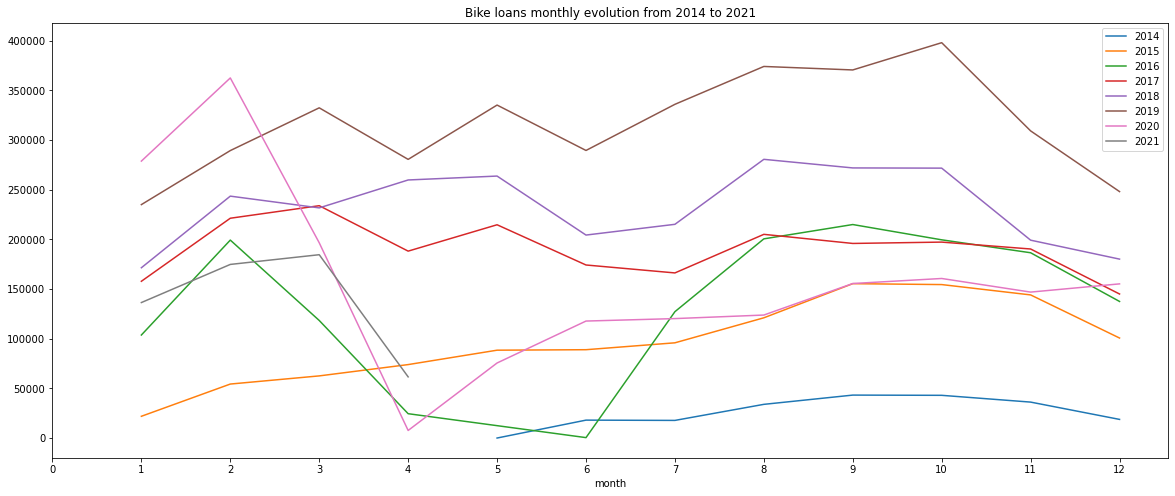

In [8]:
#Seeing yearly evolution and monthly patterns

count_df = loans_df.groupby(['year','month']).count()[['loan_id']].rename(columns={'loan_id':'nr_trips'}).reset_index()

fig, axes = plt.subplots()

for year in np.sort(loans_df['year'].unique()):
    count_df[count_df['year']==year].plot(x= 'month', y='nr_trips',
                                          ax = axes,
                                          figsize = (20, 8),
                                          xticks = range(0,13)
                                         )

plt.title('Bike loans monthly evolution from 2014 to 2021')
plt.legend(np.sort(loans_df['year'].unique()))
plt.show()

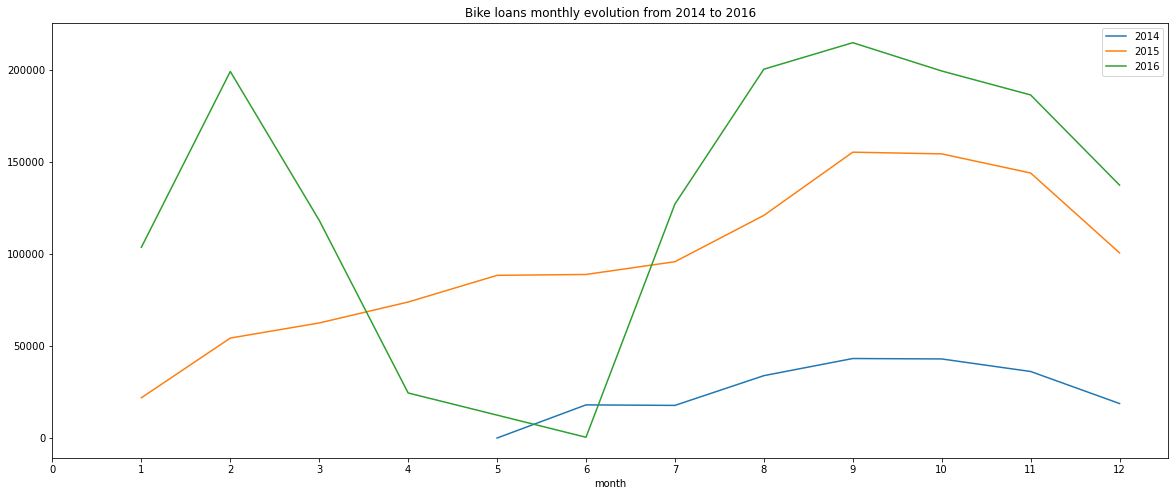

In [9]:
fig, axes = plt.subplots()

for year in range(2014,2017):
    count_df[count_df['year']==year].plot(x= 'month', y='nr_trips',
                                          ax = axes,
                                          figsize = (20, 8),
                                          xticks = range(0,13)
                                         )

plt.title('Bike loans monthly evolution from 2014 to 2016')
plt.legend(range(2014,2017))
plt.show()

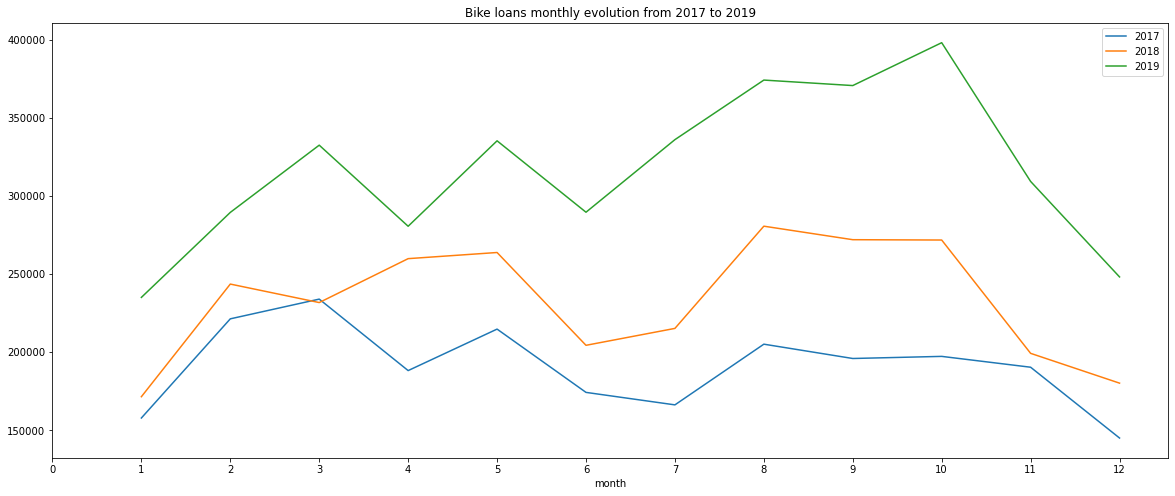

In [10]:
fig, axes = plt.subplots()

for year in range(2017,2020):
    count_df[count_df['year']==year].plot(x= 'month', y='nr_trips',
                                          ax = axes,
                                          figsize = (20, 8),
                                          xticks = range(0,13)
                                         )

plt.title('Bike loans monthly evolution from 2017 to 2019')
plt.legend(range(2017,2020))
plt.show()

In [11]:
loans_df = loans_df[(loans_df['year']>=2017)&(loans_df['year']<=2019)]

loans_df.shape[0]

8881499

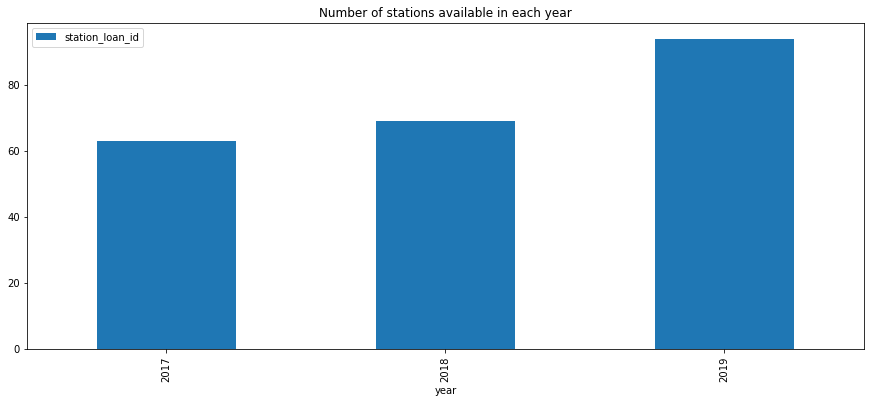

In [12]:
loans_df[['year','station_loan_id']].drop_duplicates().groupby('year').count().plot(y='station_loan_id', use_index = True, 
                                                                                    figsize = (15, 6),
                                                                                    kind='bar')
plt.title('Number of stations available in each year')
plt.show()

In [13]:
# Using only data from 2016 to 2019

In [14]:
loans_df.head()

loan_id  user_id   bike_tag_id     time_start_loan      time_stop_loan  \
0  6501462    18701  000017B00743 2017-06-21 14:22:11 2017-06-21 14:38:29   
1  6501318    41811  000017AFF83C 2017-06-21 14:07:18 2017-06-21 14:39:06   
2  6501489    96620  000017AFFB6F 2017-06-21 14:25:11 2017-06-21 14:39:07   
3  6501001    16055  0000182A3B7B 2017-06-21 13:35:52 2017-06-21 14:39:22   
4  6501421     6431  000017AFE810 2017-06-21 14:17:56 2017-06-21 14:39:26   

   station_loan_id  origin_position  station_returned_id  destined_position  \
0                8                1                 43.0                1.0   
1               56                6                 54.0                NaN   
2               36               25                  9.0               13.0   
3                8                1                  9.0                6.0   
4               56               14                 54.0                NaN   

    worker_name  year  month  weekday  hour  
0  jhon.castano  2017      6        2    14  
1       monitor  2017      6        2    14  
2           NaN  2017      6        2    14  
3           NaN  2017      6        2    13  
4       monitor  2017      6        2    14

In [15]:
loans_df['trip_duration'] = np.round((loans_df['time_stop_loan']-loans_df['time_start_loan'])/np.timedelta64(1, 'm'),2)

In [16]:
outliers_df = loans_df[(loans_df['trip_duration'] <= 1) | (loans_df['trip_duration'] >= 90)]

print(f"% of trips below 1 minute or over 1.5 hours: {np.round(outliers_df.shape[0]/loans_df.shape[0],4)*100}")

% of trips below 1 minute or over 1.5 hours: 4.569999999999999


#### Since trips below 1 minute or over 1.5 hours, theoretically, don't represent actual trips but rather mistakes when recording the data or similar and accounting for it's weight in the dataset, the team considers them outliers.

In [17]:
#Removing the outliers

loans_df = loans_df[~loans_df.index.isin(outliers_df.index)]

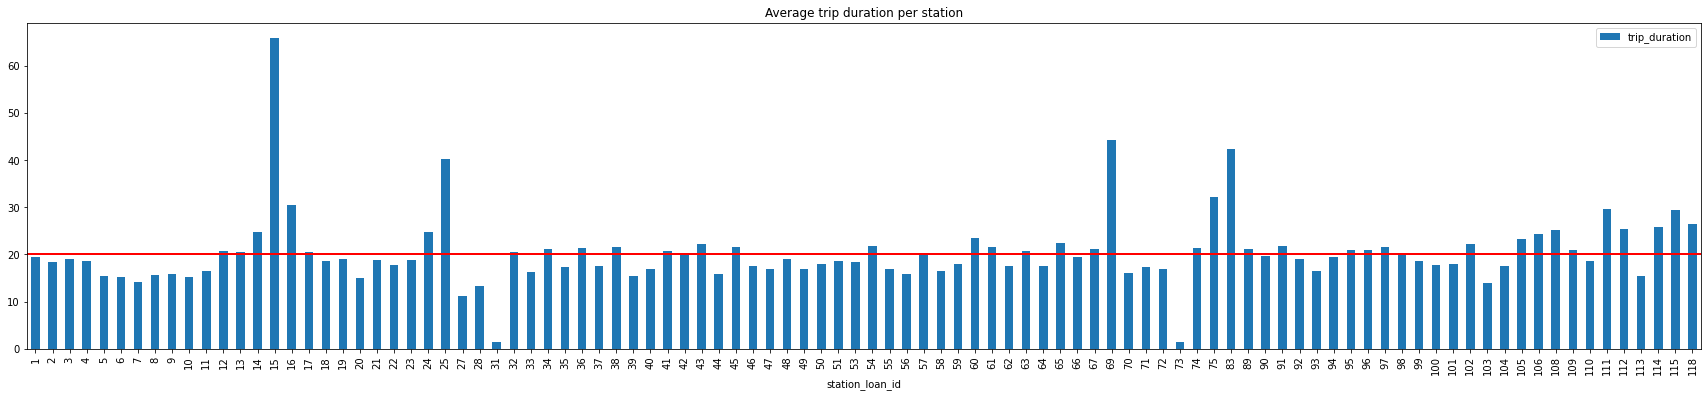

In [18]:
#Plotting the average duration of trip per station along with the average total trip duration

loans_df.groupby(['station_loan_id']).mean()[['trip_duration']].plot(kind='bar',
                                                                     figsize = (30, 6))

mean_duration = np.average(loans_df.groupby(['station_loan_id']).mean()['trip_duration'])

plt.title('Average trip duration per station')
plt.axhline(y=20, xmin=0, xmax=151,
            linewidth=2, color='r')
plt.show()

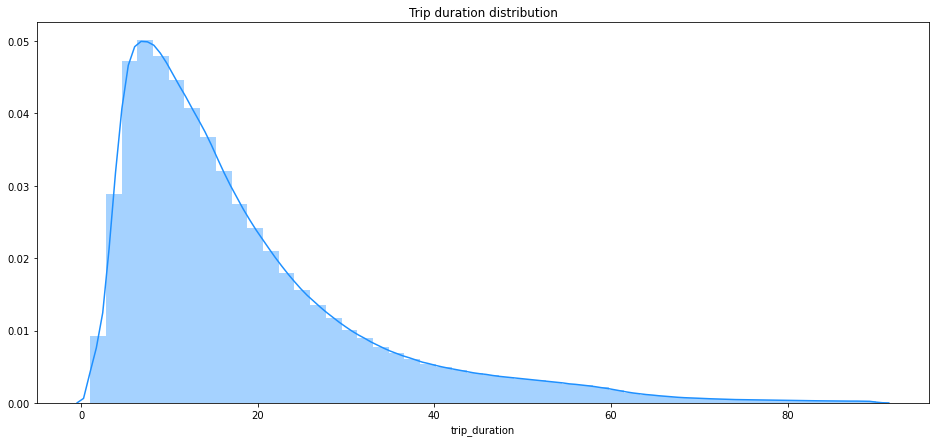

In [19]:

plt.figure(figsize=(16,7))
sns.distplot(loans_df['trip_duration'], color="dodgerblue", label="Compact")
plt.title('Trip duration distribution')
plt.show()


# At what time of the day do we need more bikes? And the least?

### Weekday Analysis

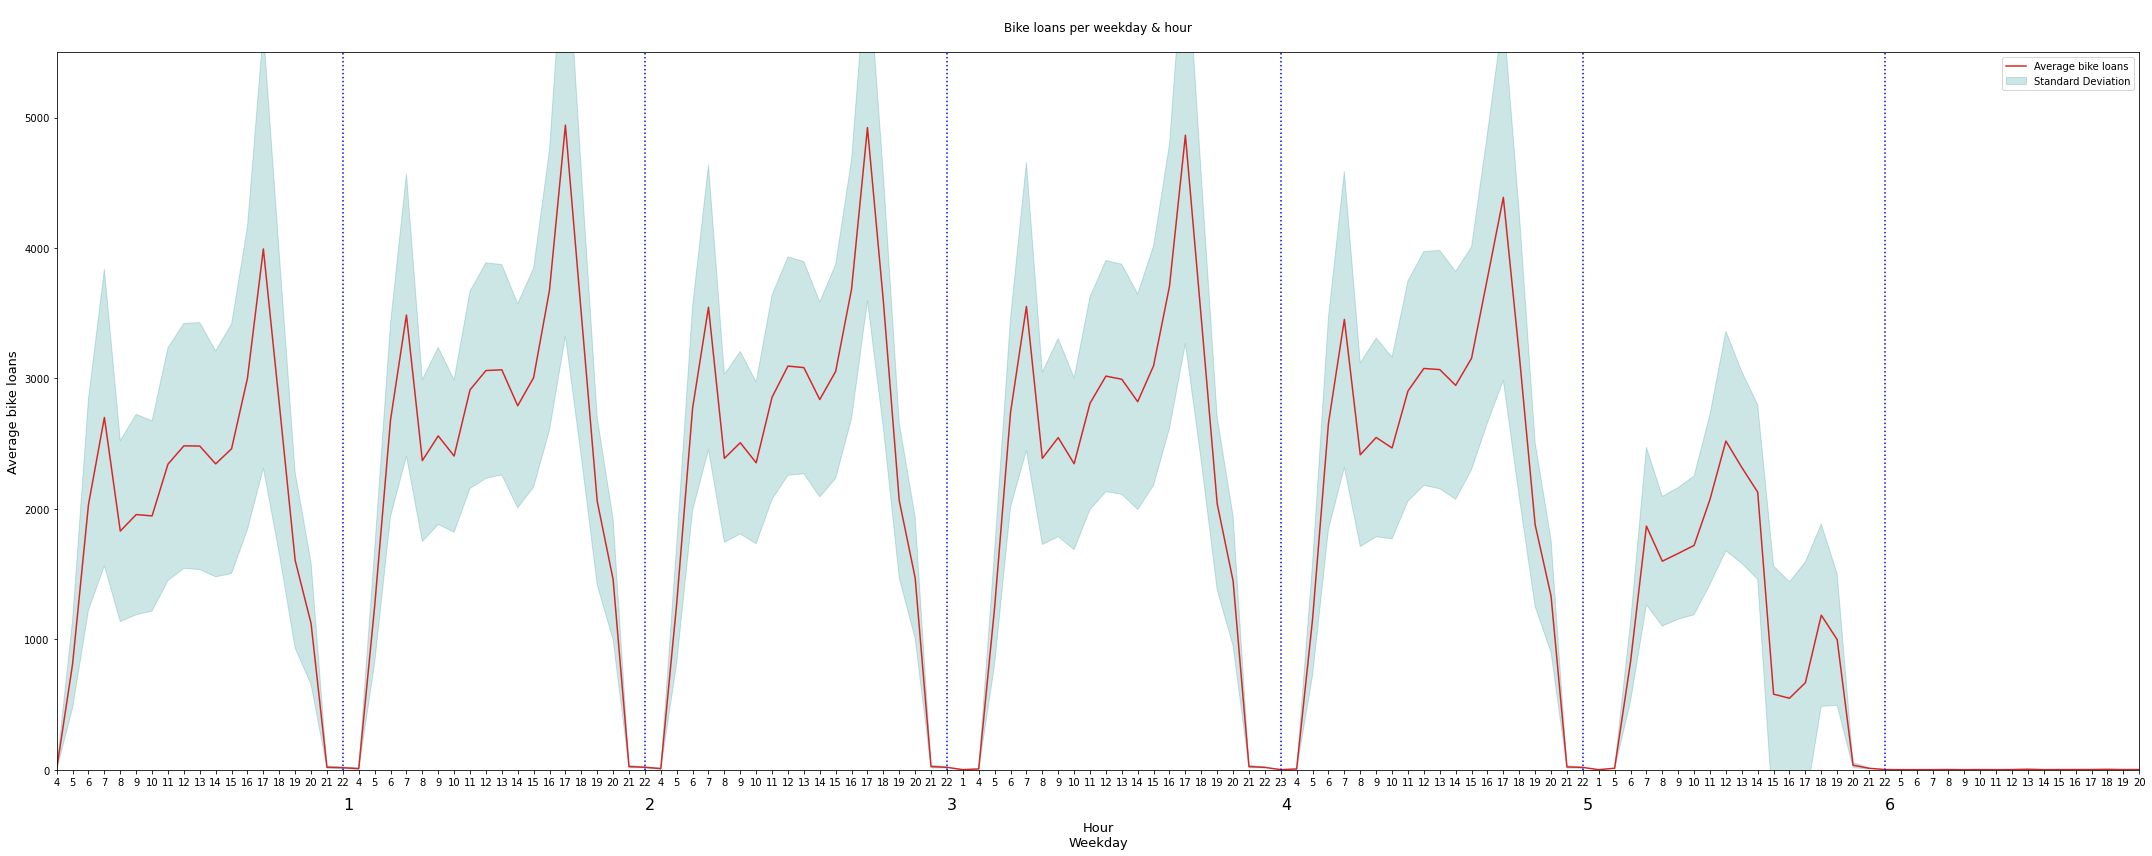

In [20]:
metrics_df = loans_df.groupby(['year','month','weekday','hour']).count()[['loan_id']].reset_index().groupby(['weekday','hour'])['loan_id'].agg(['mean', 'std']).reset_index()

fig, ax = plt.subplots(figsize=(30,12))

ax.fill_between(metrics_df.index,
metrics_df['mean']-metrics_df['std'],
metrics_df['mean']+metrics_df['std'],
color= 'teal', alpha=0.2, label = 'Standard Deviation')

metrics_df['mean'].plot(ax=ax, c='C3', label= 'Average bike loans')

ax.set_ylabel("Average bike loans", fontsize = 13)
ax.set_xlabel("\n\nHour\nWeekday", fontsize = 13)
ax.set_xticks(list(metrics_df.index))
ax.set_xticklabels(metrics_df['hour'])
for row in range(metrics_df.index[0], metrics_df.index[-1]):
    if metrics_df['weekday'][row] != metrics_df['weekday'][row+1]:
        plt.axvline(x=row, ls=':', c='b', label = '_nolegend_')
        plt.text(row, metrics_df['mean'][row], metrics_df['weekday'][row+1],
                horizontalalignment='left',
                fontsize = 16,
                position=(row,-300))

plt.ylim((0, 5500))
plt.xlim((metrics_df.index[0], metrics_df.index[-1]))
plt.title("\nBike loans per weekday & hour\n")
plt.tight_layout()
plt.legend()
plt.show()

In [21]:
# https://nycdatascience.com/blog/student-works/capstone/solving-the-citibike-station-rebalancing-issue-with-python-machine-learning/

# See best combination between station_loan_id and station_returned_id...

...to see what are the routes people do more often. This way, we can see the most used destinations and origin

In [22]:
#loans_df.groupby(['station_loan_id','station_returned_id']).count()['loan_id'].sort_values(ascending=False).plot.barh()

# Number of trips per month

In [23]:
loans_df.groupby('month').count()['loan_id']

month
1     533919
2     722727
3     760626
4     698433
5     777383
6     639161
7     686876
8     824264
9     805108
10    832147
11    664281
12    531067
Name: loan_id, dtype: int64

# Do people prefer manual or automatic? Search for news about this bike sharing system

In [24]:
loans_df.groupby('station_returned_id').count()['loan_id'].sort_values(ascending=False)

station_returned_id
8.0     447044
7.0     371965
12.0    331803
67.0    307083
3.0     298968
         ...  
80.0         1
82.0         1
84.0         1
85.0         1
88.0         1
Name: loan_id, Length: 109, dtype: int64

## Station Details dataset - 95 stations in common
(https://github.com/hugonne/ds4a-encicla/blob/master/data/Estaciones_datos_metereologico.csv)

In [25]:
stations_df = pd.read_csv('data/station_location_with_id.csv', sep=';',encoding='utf-8')

In [26]:
stations_df.head()

ID           Description  numSlots shortName       Lat         Lon  \
0   1               Moravia        15       MRV  6,276585  -75,564804   
1   2           Universidad        33       UNI  6,269267    -75,5653   
2   3                Ruta N        40       RTN  6,265182  -75,566348   
3   4            Punto Cero        10       PT0  6,265161  -75,575066   
4   5  Universidad Nacional        33       NaN  6,259663  -75,578812   

   isManual                                     webDescription  \
0         1  Frente a la entrada principal del Centro de De...   
1         1  Bajo el viaducto de la estación Universidad de...   
2         0  Frente a la fachada principal de Ruta N sobre ...   
3         1  Intercambio vial de Punto Cero al lado de la e...   
4         1  Portería de la Iguaná con Carrera 65 de la Uni...   

                                               photo  
0  https://encicla.metropol.gov.co/imgstations/mo...  
1  https://encicla.metropol.gov.co/imgstations/un...  
2  https://encicla.metropol.gov.co/imgstations/ru...  
3  https://encicla.metropol.gov.co/imgstations/pu...  
4  https://encicla.metropol.gov.co/imgstations/un...

In [27]:
stations_df.Lat = stations_df['Lat'].apply(lambda x: x.replace(',','.'))
stations_df.Lat = pd.to_numeric(stations_df.Lat, downcast="float")

stations_df.Lon = stations_df['Lon'].apply(lambda x: x.replace(',','.'))
stations_df.Lon = pd.to_numeric(stations_df.Lon, downcast="float")

In [28]:
geo_df = gpd.GeoDataFrame(
    stations_df, geometry=gpd.points_from_xy(stations_df.Lon, stations_df.Lat))

In [29]:
geo_df.head()

ID           Description  numSlots shortName       Lat        Lon  \
0   1               Moravia        15       MRV  6.276585 -75.564804   
1   2           Universidad        33       UNI  6.269267 -75.565300   
2   3                Ruta N        40       RTN  6.265182 -75.566345   
3   4            Punto Cero        10       PT0  6.265161 -75.575066   
4   5  Universidad Nacional        33       NaN  6.259663 -75.578812   

   isManual                                     webDescription  \
0         1  Frente a la entrada principal del Centro de De...   
1         1  Bajo el viaducto de la estación Universidad de...   
2         0  Frente a la fachada principal de Ruta N sobre ...   
3         1  Intercambio vial de Punto Cero al lado de la e...   
4         1  Portería de la Iguaná con Carrera 65 de la Uni...   

                                               photo  \
0  https://encicla.metropol.gov.co/imgstations/mo...   
1  https://encicla.metropol.gov.co/imgstations/un...   
2  https://encicla.metropol.gov.co/imgstations/ru...   
3  https://encicla.metropol.gov.co/imgstations/pu...   
4  https://encicla.metropol.gov.co/imgstations/un...   

                    geometry  
0  POINT (-75.56480 6.27659)  
1  POINT (-75.56530 6.26927)  
2  POINT (-75.56635 6.26518)  
3  POINT (-75.57507 6.26516)  
4  POINT (-75.57881 6.25966)

In [30]:
geo_df['Center_point'] = geo_df['geometry'].centroid
# Extract lat and lon from the centerpoint
geo_df["Lat"] = geo_df.Center_point.map(lambda p: p.x)
geo_df["Lon"] = geo_df.Center_point.map(lambda p: p.y)

geo_df.crs = "EPSG:4326"
geo_df = geo_df.to_crs(epsg=3857)

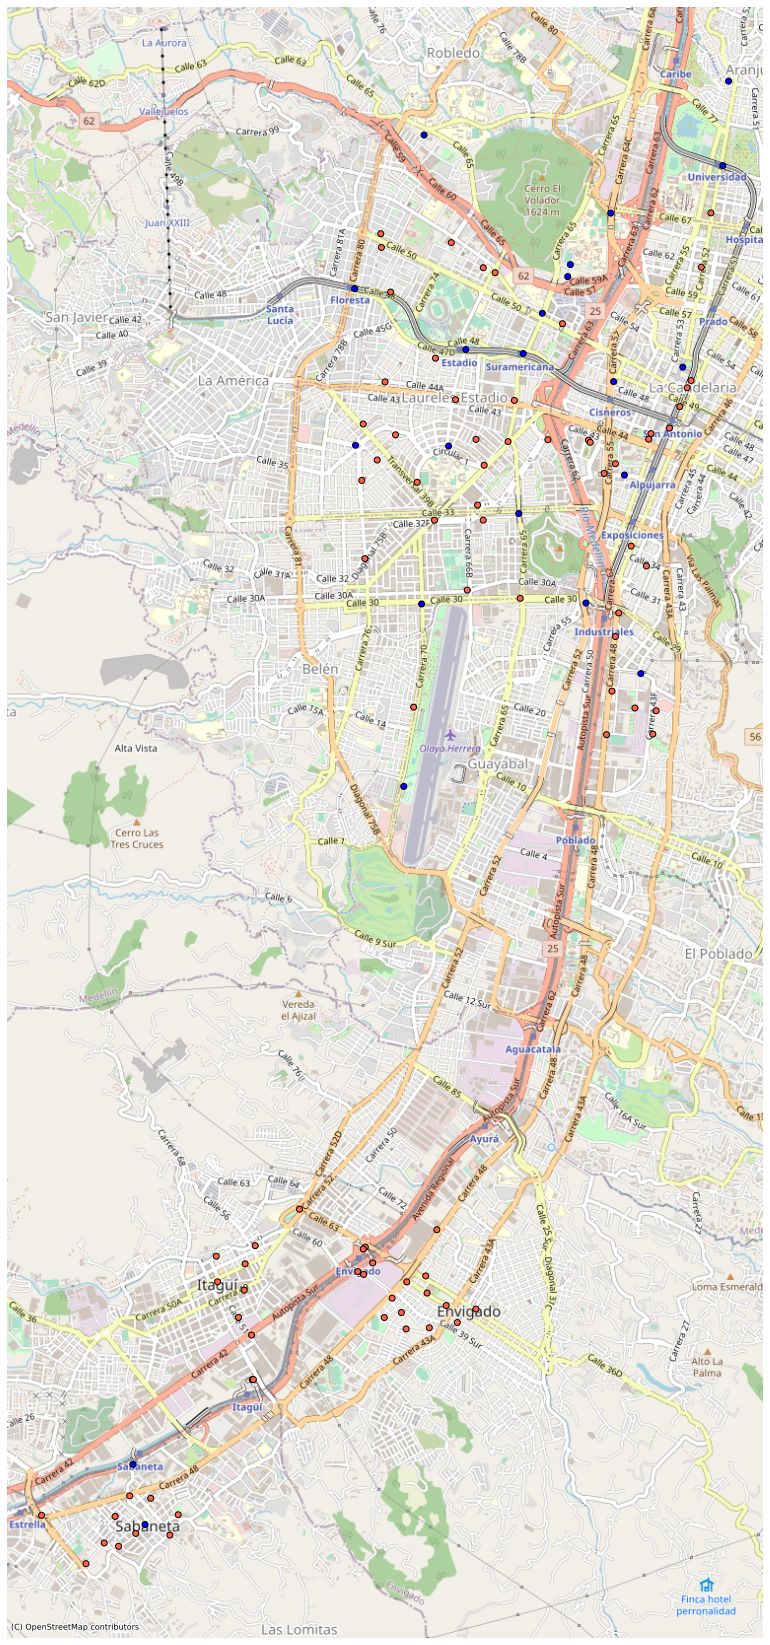

In [31]:
point_color = (geo_df['isManual'] > 0).map({True: 'blue', False: 'tomato'})

ax = geo_df.plot(figsize=(20, 30), color = point_color, alpha = 1, edgecolor = 'k')

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik, zoom = 14)
ax.set_axis_off()


All Envigado stations are automatic, and so are most of Sabaneta's. Manual stations (represented by the blue dots) are mostly located in the Northern part of the Aburrá Valley.

In [32]:
geo_df[geo_df['ID']==70]

ID      Description  numSlots shortName        Lat       Lon  isManual  \
55  70  Campus Nacional        33       NAC -75.578583  6.260703         1   

                                       webDescription photo  \
55  Portería de la Iguaná con Carrera 65 de la Uni...   NaN   

                           geometry               Center_point  
55  POINT (-8413369.348 698329.330)  POINT (-75.57858 6.26070)

In [33]:
geo_df.head()

ID           Description  numSlots shortName        Lat       Lon  \
0   1               Moravia        15       MRV -75.564804  6.276585   
1   2           Universidad        33       UNI -75.565300  6.269267   
2   3                Ruta N        40       RTN -75.566345  6.265182   
3   4            Punto Cero        10       PT0 -75.575066  6.265161   
4   5  Universidad Nacional        33       NaN -75.578812  6.259663   

   isManual                                     webDescription  \
0         1  Frente a la entrada principal del Centro de De...   
1         1  Bajo el viaducto de la estación Universidad de...   
2         0  Frente a la fachada principal de Ruta N sobre ...   
3         1  Intercambio vial de Punto Cero al lado de la e...   
4         1  Portería de la Iguaná con Carrera 65 de la Uni...   

                                               photo  \
0  https://encicla.metropol.gov.co/imgstations/mo...   
1  https://encicla.metropol.gov.co/imgstations/un...   
2  https://encicla.metropol.gov.co/imgstations/ru...   
3  https://encicla.metropol.gov.co/imgstations/pu...   
4  https://encicla.metropol.gov.co/imgstations/un...   

                          geometry               Center_point  
0  POINT (-8411835.512 700107.943)  POINT (-75.56480 6.27659)  
1  POINT (-8411890.716 699288.398)  POINT (-75.56530 6.26927)  
2  POINT (-8412007.070 698830.916)  POINT (-75.56635 6.26518)  
3  POINT (-8412977.821 698828.567)  POINT (-75.57507 6.26516)  
4  POINT (-8413394.827 698212.866)  POINT (-75.57881 6.25966)

In [34]:
print(f"Manual stations represent {np.round((geo_df[geo_df['isManual']==1].shape[0]/geo_df.shape[0])*100,2)}% of all stations.")

Manual stations represent 20.56% of all stations.
